In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/20241114_150555.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/20241114_145527.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_144634.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_155701.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_154546.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_161614.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/20241114_150917.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/20241114_152001.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_155923.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_152354.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_160709.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/20241114_150912.jpg
/kaggle/input/dataset-rice-disease-rm/Tungro/orginal/IMG_20241114_161917.jpg
/kaggle/input/datas

In [ ]:
# 1. Imports
import os
import shutil
import random
from glob import glob
import numpy as np
import tensorflow as tf
import optuna
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# 2. Split Dataset
source_dir = '/kaggle/input/dataset-rice-disease-rm'
train_dir = '/kaggle/working/data/train'
val_dir = '/kaggle/working/data/val'
val_split = 0.2
random.seed(42)
valid_ext = ('.jpg', '.jpeg', '.png')

for label in os.listdir(source_dir):
    class_path = os.path.join(source_dir, label)
    if os.path.isdir(class_path):
        image_paths = []
        for ext in valid_ext:
            image_paths.extend(glob(os.path.join(class_path, '**', f'*{ext}'), recursive=True))
        random.shuffle(image_paths)
        split_idx = int(len(image_paths) * (1 - val_split))
        train_images = image_paths[:split_idx]
        val_images = image_paths[split_idx:]
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
        os.makedirs(os.path.join(val_dir, label), exist_ok=True)
        for src_path in train_images:
            shutil.copy(src_path, os.path.join(train_dir, label, os.path.basename(src_path)))
        for src_path in val_images:
            shutil.copy(src_path, os.path.join(val_dir, label, os.path.basename(src_path)))


2025-05-14 07:40:56.161498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747208456.379790      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747208456.446140      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# 3. Image Generators
img_size = (224, 224)
batch_size = 32

def build_generators(preprocess_func):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True)
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator

train_generator, val_generator = build_generators(resnet50_preprocess)
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))


# 4. Optuna Objective Function
trial_histories = {}

best_val_acc = -np.inf
best_model = None

def objective(trial):
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.3, 0.4, 0.5, 0.6])
    dense_units = trial.suggest_categorical("dense_units", [256, 512])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    learning_rate = trial.suggest_categorical("learning_rate", [1e-4, 1e-5, 1e-6])
    unfrozen_layers = trial.suggest_categorical("unfrozen_layers", [0, 20, 40, 60, 80, 100])

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfrozen_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)
    ]

    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    val_acc = max(history.history["val_accuracy"])
    trial_histories[trial.number] = history.history
    
    global best_model
    global best_val_acc
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        
    return val_acc


# 5. Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=12)


# 6. Best Trial Result
print("Best Trial:")
print(study.best_trial.params)
best_history = trial_histories[study.best_trial.number]


Found 8611 images belonging to 5 classes.
Found 2155 images belonging to 5 classes.


[I 2025-05-14 09:13:24,558] A new study created in memory with name: no-name-1ed6c30d-f6b0-4d4e-9e45-67aa44c565ed


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 181s 600ms/step - accuracy: 0.3955 - loss: 1.3378 - val_accuracy: 0.6770 - val_loss: 0.8146 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 568ms/step - accuracy: 0.6543 - loss: 0.6959 - val_accuracy: 0.7392 - val_loss: 0.6440 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 565ms/step - accuracy: 0.7651 - loss: 0.4826 - val_accuracy: 0.8316 - val_loss: 0.4738 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 156s 562ms/step - accuracy: 0.7772 - loss: 0.4550 - val_accuracy: 0.8265 - val_loss: 0.4556 - learning_rate: 1.0000e-04
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 166s 597ms/step - accuracy: 0.7826 - loss: 0.4195 - val_accuracy: 0.7972 - val_loss: 0.5003 - learning_rate: 1.0000e-04
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 156s 564ms/step - accuracy: 0.8027 - loss: 0.3960 - val_accuracy: 0.8394 - val_loss: 0.4222 - learning_rate: 5.0000e-05
Epoch 8/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 158s 572ms/

[I 2025-05-14 09:50:42,402] Trial 0 finished with value: 0.8756380677223206 and parameters: {'dropout_rate': 0.4, 'dense_units': 512, 'optimizer': 'sgd', 'learning_rate': 0.0001, 'unfrozen_layers': 40}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 184s 614ms/step - accuracy: 0.2464 - loss: 2.0458 - val_accuracy: 0.4278 - val_loss: 1.3486 - learning_rate: 1.0000e-05
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 566ms/step - accuracy: 0.3271 - loss: 1.5450 - val_accuracy: 0.4933 - val_loss: 1.2157 - learning_rate: 1.0000e-05
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 158s 571ms/step - accuracy: 0.3799 - loss: 1.3420 - val_accuracy: 0.5123 - val_loss: 1.1368 - learning_rate: 1.0000e-05
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 159s 575ms/step - accuracy: 0.4133 - loss: 1.2357 - val_accuracy: 0.5439 - val_loss: 1.0780 - learning_rate: 1.0000e-05
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 557ms/step - accuracy: 0.4366 - loss: 1.1574 - val_accuracy: 0.5805 - val_loss: 1.0139 - learning_rate: 1.0000e-05
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 556ms/step - accuracy: 0.4544 - loss: 1.0915 - val_accuracy: 0.6005 - val_loss: 0.9712 - learning_rate: 1.0000e-05
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 10:30:06,976] Trial 1 finished with value: 0.7081206440925598 and parameters: {'dropout_rate': 0.6, 'dense_units': 256, 'optimizer': 'sgd', 'learning_rate': 1e-05, 'unfrozen_layers': 20}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 179s 594ms/step - accuracy: 0.2043 - loss: 2.0592 - val_accuracy: 0.4167 - val_loss: 1.3853 - learning_rate: 1.0000e-05
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 158s 570ms/step - accuracy: 0.3473 - loss: 1.4363 - val_accuracy: 0.4993 - val_loss: 1.2345 - learning_rate: 1.0000e-05
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 566ms/step - accuracy: 0.4062 - loss: 1.2641 - val_accuracy: 0.5332 - val_loss: 1.1287 - learning_rate: 1.0000e-05
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 561ms/step - accuracy: 0.4496 - loss: 1.1424 - val_accuracy: 0.5675 - val_loss: 1.0598 - learning_rate: 1.0000e-05
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 559ms/step - accuracy: 0.4729 - loss: 1.0781 - val_accuracy: 0.5875 - val_loss: 1.0157 - learning_rate: 1.0000e-05
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 551ms/step - accuracy: 0.4833 - loss: 1.0214 - val_accuracy: 0.5907 - val_loss: 0.9900 - learning_rate: 1.0000e-05
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 11:08:55,946] Trial 2 finished with value: 0.7011600732803345 and parameters: {'dropout_rate': 0.6, 'dense_units': 256, 'optimizer': 'sgd', 'learning_rate': 1e-05, 'unfrozen_layers': 40}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 174s 579ms/step - accuracy: 0.2430 - loss: 1.9230 - val_accuracy: 0.4900 - val_loss: 1.3356 - learning_rate: 1.0000e-05
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 550ms/step - accuracy: 0.3630 - loss: 1.3727 - val_accuracy: 0.5601 - val_loss: 1.1642 - learning_rate: 1.0000e-05
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 548ms/step - accuracy: 0.4393 - loss: 1.2100 - val_accuracy: 0.5903 - val_loss: 1.0652 - learning_rate: 1.0000e-05
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 556ms/step - accuracy: 0.4769 - loss: 1.0908 - val_accuracy: 0.6339 - val_loss: 0.9869 - learning_rate: 1.0000e-05
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 151s 545ms/step - accuracy: 0.5084 - loss: 1.0360 - val_accuracy: 0.6445 - val_loss: 0.9364 - learning_rate: 1.0000e-05
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 550ms/step - accuracy: 0.5496 - loss: 0.9265 - val_accuracy: 0.6677 - val_loss: 0.8811 - learning_rate: 1.0000e-05
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 11:47:35,499] Trial 3 finished with value: 0.7577726244926453 and parameters: {'dropout_rate': 0.6, 'dense_units': 256, 'optimizer': 'sgd', 'learning_rate': 1e-05, 'unfrozen_layers': 40}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 178s 588ms/step - accuracy: 0.2376 - loss: 1.9624 - val_accuracy: 0.4297 - val_loss: 1.3393 - learning_rate: 1.0000e-05
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 567ms/step - accuracy: 0.3564 - loss: 1.4158 - val_accuracy: 0.5077 - val_loss: 1.1882 - learning_rate: 1.0000e-05
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 555ms/step - accuracy: 0.4174 - loss: 1.2253 - val_accuracy: 0.5248 - val_loss: 1.1004 - learning_rate: 1.0000e-05
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 559ms/step - accuracy: 0.4328 - loss: 1.1310 - val_accuracy: 0.5647 - val_loss: 1.0285 - learning_rate: 1.0000e-05
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 549ms/step - accuracy: 0.4866 - loss: 1.0283 - val_accuracy: 0.5842 - val_loss: 0.9890 - learning_rate: 1.0000e-05
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 561ms/step - accuracy: 0.5102 - loss: 0.9808 - val_accuracy: 0.6232 - val_loss: 0.9259 - learning_rate: 1.0000e-05
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 12:27:04,877] Trial 4 finished with value: 0.7382830381393433 and parameters: {'dropout_rate': 0.6, 'dense_units': 512, 'optimizer': 'sgd', 'learning_rate': 1e-05, 'unfrozen_layers': 60}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 186s 588ms/step - accuracy: 0.2518 - loss: 1.8325 - val_accuracy: 0.4659 - val_loss: 1.2677 - learning_rate: 1.0000e-06
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 557ms/step - accuracy: 0.4107 - loss: 1.2356 - val_accuracy: 0.5100 - val_loss: 1.1035 - learning_rate: 1.0000e-06
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 149s 541ms/step - accuracy: 0.4887 - loss: 1.0242 - val_accuracy: 0.5903 - val_loss: 0.9736 - learning_rate: 1.0000e-06
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 551ms/step - accuracy: 0.5581 - loss: 0.8992 - val_accuracy: 0.6524 - val_loss: 0.8499 - learning_rate: 1.0000e-06
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 151s 547ms/step - accuracy: 0.6109 - loss: 0.8131 - val_accuracy: 0.6807 - val_loss: 0.7816 - learning_rate: 1.0000e-06
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 151s 545ms/step - accuracy: 0.6366 - loss: 0.7415 - val_accuracy: 0.7290 - val_loss: 0.6809 - learning_rate: 1.0000e-06
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 13:05:28,958] Trial 5 finished with value: 0.8157772421836853 and parameters: {'dropout_rate': 0.5, 'dense_units': 512, 'optimizer': 'adam', 'learning_rate': 1e-06, 'unfrozen_layers': 80}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 175s 575ms/step - accuracy: 0.3890 - loss: 1.4002 - val_accuracy: 0.6348 - val_loss: 0.8554 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 549ms/step - accuracy: 0.6323 - loss: 0.7406 - val_accuracy: 0.7722 - val_loss: 0.6143 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 550ms/step - accuracy: 0.6957 - loss: 0.5972 - val_accuracy: 0.7708 - val_loss: 0.5803 - learning_rate: 1.0000e-04
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 557ms/step - accuracy: 0.7298 - loss: 0.5241 - val_accuracy: 0.7745 - val_loss: 0.5574 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 551ms/step - accuracy: 0.7654 - loss: 0.4727 - val_accuracy: 0.8200 - val_loss: 0.4770 - learning_rate: 1.0000e-04
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 548ms/step - accuracy: 0.7888 - loss: 0.4204 - val_accuracy: 0.8394 - val_loss: 0.4280 - learning_rate: 1.0000e-04
Epoch 8/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 13:44:01,102] Trial 6 finished with value: 0.8700696229934692 and parameters: {'dropout_rate': 0.6, 'dense_units': 512, 'optimizer': 'sgd', 'learning_rate': 0.0001, 'unfrozen_layers': 60}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 172s 571ms/step - accuracy: 0.2194 - loss: 1.9874 - val_accuracy: 0.4260 - val_loss: 1.3559 - learning_rate: 1.0000e-05
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 150s 540ms/step - accuracy: 0.3701 - loss: 1.4066 - val_accuracy: 0.4937 - val_loss: 1.1819 - learning_rate: 1.0000e-05
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 149s 538ms/step - accuracy: 0.4214 - loss: 1.2171 - val_accuracy: 0.5490 - val_loss: 1.0830 - learning_rate: 1.0000e-05
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 567ms/step - accuracy: 0.4481 - loss: 1.1473 - val_accuracy: 0.5926 - val_loss: 1.0065 - learning_rate: 1.0000e-05
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 549ms/step - accuracy: 0.4836 - loss: 1.0509 - val_accuracy: 0.6065 - val_loss: 0.9491 - learning_rate: 1.0000e-05
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 559ms/step - accuracy: 0.5383 - loss: 0.9534 - val_accuracy: 0.6260 - val_loss: 0.9036 - learning_rate: 1.0000e-05
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 14:22:36,595] Trial 7 finished with value: 0.7299304008483887 and parameters: {'dropout_rate': 0.5, 'dense_units': 512, 'optimizer': 'sgd', 'learning_rate': 1e-05, 'unfrozen_layers': 40}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 206s 607ms/step - accuracy: 0.2407 - loss: 2.1209 - val_accuracy: 0.4204 - val_loss: 1.4182 - learning_rate: 1.0000e-06
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 550ms/step - accuracy: 0.3560 - loss: 1.3722 - val_accuracy: 0.4882 - val_loss: 1.1890 - learning_rate: 1.0000e-06
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 552ms/step - accuracy: 0.4552 - loss: 1.1030 - val_accuracy: 0.5582 - val_loss: 1.0139 - learning_rate: 1.0000e-06
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 162s 584ms/step - accuracy: 0.5072 - loss: 0.9587 - val_accuracy: 0.6450 - val_loss: 0.8821 - learning_rate: 1.0000e-06
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 164s 591ms/step - accuracy: 0.5772 - loss: 0.8105 - val_accuracy: 0.6914 - val_loss: 0.7825 - learning_rate: 1.0000e-06
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 556ms/step - accuracy: 0.6235 - loss: 0.7299 - val_accuracy: 0.7466 - val_loss: 0.6662 - learning_rate: 1.0000e-06
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 15:02:20,819] Trial 8 finished with value: 0.8222737908363342 and parameters: {'dropout_rate': 0.6, 'dense_units': 512, 'optimizer': 'adam', 'learning_rate': 1e-06, 'unfrozen_layers': 0}. Best is trial 0 with value: 0.8756380677223206.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 182s 593ms/step - accuracy: 0.5794 - loss: 0.8737 - val_accuracy: 0.8283 - val_loss: 0.4699 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 553ms/step - accuracy: 0.7653 - loss: 0.4541 - val_accuracy: 0.8232 - val_loss: 0.4424 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 556ms/step - accuracy: 0.7995 - loss: 0.4091 - val_accuracy: 0.8329 - val_loss: 0.4593 - learning_rate: 1.0000e-04
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 150s 542ms/step - accuracy: 0.8597 - loss: 0.2927 - val_accuracy: 0.8821 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 151s 547ms/step - accuracy: 0.8549 - loss: 0.2969 - val_accuracy: 0.8701 - val_loss: 0.3917 - learning_rate: 1.0000e-04
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 551ms/step - accuracy: 0.8674 - loss: 0.2696 - val_accuracy: 0.8868 - val_loss: 0.2828 - learning_rate: 1.0000e-04
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 15:41:48,190] Trial 9 finished with value: 0.9313225150108337 and parameters: {'dropout_rate': 0.3, 'dense_units': 512, 'optimizer': 'adam', 'learning_rate': 0.0001, 'unfrozen_layers': 40}. Best is trial 9 with value: 0.9313225150108337.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 189s 593ms/step - accuracy: 0.5521 - loss: 0.8907 - val_accuracy: 0.6441 - val_loss: 0.8080 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 561ms/step - accuracy: 0.7208 - loss: 0.5750 - val_accuracy: 0.7977 - val_loss: 0.4986 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 553ms/step - accuracy: 0.7955 - loss: 0.4360 - val_accuracy: 0.8070 - val_loss: 0.4281 - learning_rate: 1.0000e-04
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 156s 562ms/step - accuracy: 0.8330 - loss: 0.3377 - val_accuracy: 0.7926 - val_loss: 0.5550 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 560ms/step - accuracy: 0.8540 - loss: 0.2988 - val_accuracy: 0.8789 - val_loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 568ms/step - accuracy: 0.8564 - loss: 0.2920 - val_accuracy: 0.8524 - val_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 16:13:37,462] Trial 10 finished with value: 0.9178654551506042 and parameters: {'dropout_rate': 0.3, 'dense_units': 256, 'optimizer': 'adam', 'learning_rate': 0.0001, 'unfrozen_layers': 100}. Best is trial 9 with value: 0.9313225150108337.


Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 191s 596ms/step - accuracy: 0.5788 - loss: 0.8960 - val_accuracy: 0.8139 - val_loss: 0.4648 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 155s 560ms/step - accuracy: 0.7772 - loss: 0.4456 - val_accuracy: 0.8218 - val_loss: 0.4164 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 153s 551ms/step - accuracy: 0.8163 - loss: 0.3709 - val_accuracy: 0.8585 - val_loss: 0.3496 - learning_rate: 1.0000e-04
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 152s 550ms/step - accuracy: 0.8339 - loss: 0.3347 - val_accuracy: 0.8394 - val_loss: 0.4161 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 154s 556ms/step - accuracy: 0.8442 - loss: 0.3159 - val_accuracy: 0.8664 - val_loss: 0.3653 - learning_rate: 1.0000e-04
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 158s 572ms/step - accuracy: 0.8600 - loss: 0.2845 - val_accuracy: 0.8724 - val_loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-14 16:54:31,065] Trial 11 finished with value: 0.9299303889274597 and parameters: {'dropout_rate': 0.3, 'dense_units': 256, 'optimizer': 'adam', 'learning_rate': 0.0001, 'unfrozen_layers': 100}. Best is trial 9 with value: 0.9313225150108337.


Best Trial:
{'dropout_rate': 0.3, 'dense_units': 512, 'optimizer': 'adam', 'learning_rate': 0.0001, 'unfrozen_layers': 40}


In [9]:
best_model.save("best_resnet_model.h5")
print("Best model saved to best_resnet_model.h5")


Best model saved to best_resnet_model.h5


In [10]:
from IPython.display import FileLink

FileLink(r'best_resnet_model.h5')


/kaggle/working/best_resnet_model.h5

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Load best history from Optuna
best_history = trial_histories[study.best_trial.number]

acc = best_history['accuracy']
val_acc = best_history['val_accuracy']
loss = best_history['loss']
val_loss = best_history['val_loss']

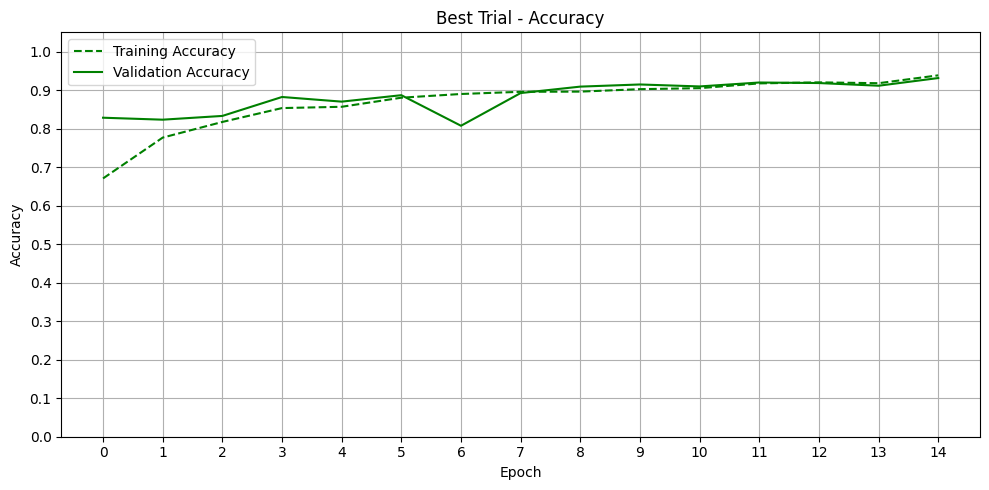

In [17]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy', linestyle='--', color='green')
plt.plot(val_acc, label='Validation Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.xticks(np.arange(0, len(acc)))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

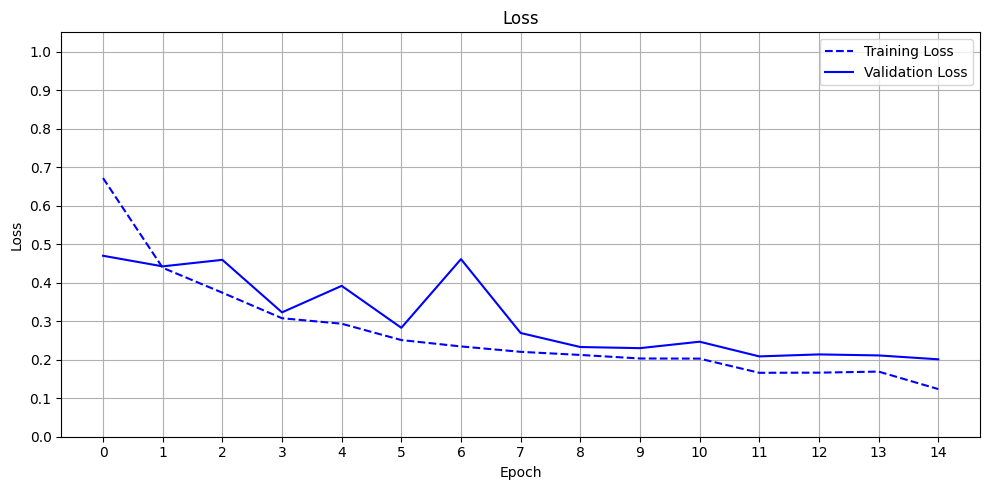

In [18]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', linestyle='--', color='blue')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.05)
plt.xticks(np.arange(0, len(acc)))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

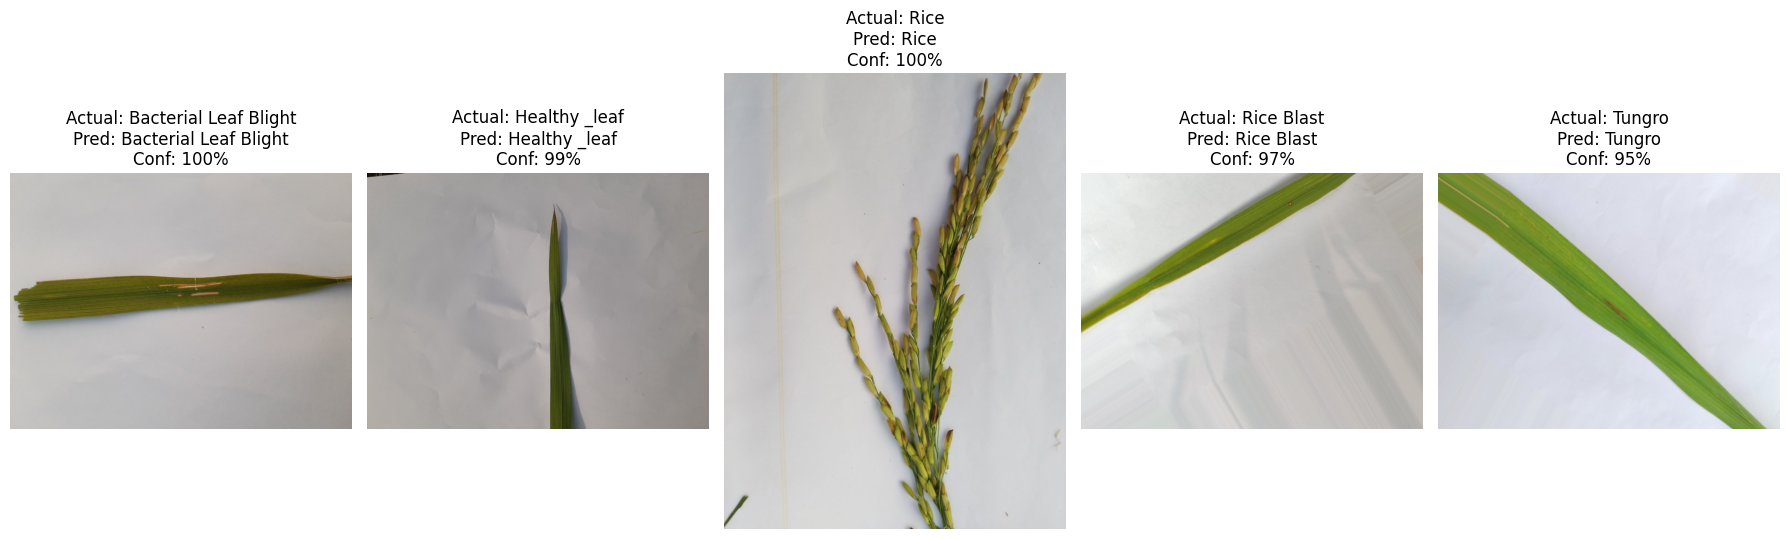

In [29]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

# Use the fine-tuned model
model = load_model("best_resnet_model.h5")

# Get class names from the training generator
class_names = list(train_generator.class_indices.keys())

def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(preds)
    confidence = float(np.max(preds))
    predicted_class = class_names[predicted_index]
    return predicted_class, confidence

# Collect one random image per class
sample_images = []
for class_dir in class_names:
    class_dir_path = os.path.join(train_dir, class_dir)
    if not os.path.isdir(class_dir_path):
        continue
    images = [img for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        random_image = random.choice(images)
        sample_images.append(os.path.join(class_dir_path, random_image))

# Plot predictions
plt.figure(figsize=(18, 6))
for i, image_path in enumerate(sample_images):
    actual_class = os.path.basename(os.path.dirname(image_path))
    predicted_class, confidence = predict_image(image_path)

    plt.subplot(1, len(sample_images), i + 1)
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_class}\nPred: {predicted_class}\nConf: {confidence:.0%}")

plt.tight_layout()
plt.savefig("one_per_class_prediction.png", format="png", dpi=300)
plt.show()


68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step


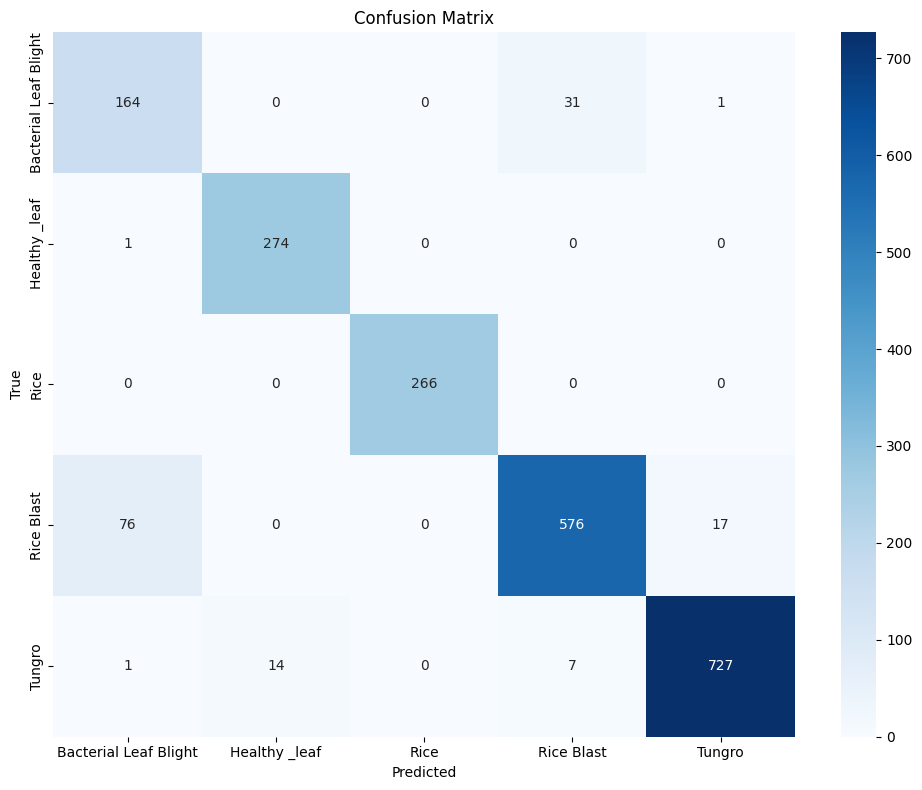

                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.68      0.84      0.75       196
        Healthy _leaf       0.95      1.00      0.97       275
                 Rice       1.00      1.00      1.00       266
           Rice Blast       0.94      0.86      0.90       669
               Tungro       0.98      0.97      0.97       749

             accuracy                           0.93      2155
            macro avg       0.91      0.93      0.92      2155
         weighted avg       0.94      0.93      0.93      2155



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get ground truth labels
val_generator.reset()
true_labels = val_generator.classes
class_indices = val_generator.class_indices
class_names = list(class_indices.keys())

# Predict
preds = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(true_labels, predicted_classes, target_names=class_names))
